In [2]:
#get data

from msmbuilder.example_datasets import FsPeptide
fs_peptide = FsPeptide()
fs_peptide.cache()

In [3]:
import tempfile
import os
os.chdir(tempfile.mkdtemp())

In [4]:
from msmbuilder.dataset import dataset
xyz = dataset(fs_peptide.data_dir + "/*.xtc",
              topology=fs_peptide.data_dir + '/fs-peptide.pdb',
              stride=10)
print("{} trajectories".format(len(xyz)))
# msmbuilder does not keep track of units! You must keep track of your
# data's timestep
to_ns = 0.5
print("with length {} ns".format(set(len(x)*to_ns for x in xyz)))

C:\Anaconda2\lib\site-packages\mdtraj\formats\pdb\pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '


28 trajectories
with length set([500.0]) ns


In [11]:
i = 5
print str(i)

5


In [4]:
#featurization

from msmbuilder.featurizer import DihedralFeaturizer
featurizer = DihedralFeaturizer(types=['phi', 'psi'])
diheds = xyz.fit_transform_with(featurizer, 'diheds/', fmt='dir-npy')

print(xyz[0].xyz.shape)
print(diheds[0].shape)

(1000L, 264L, 3L)
(1000L, 84L)


In [5]:
#tICA

from msmbuilder.decomposition import tICA
tica_model = tICA(lag_time=2, n_components=4)
# fit and transform can be done in seperate steps:
tica_model = diheds.fit_with(tica_model)
tica_trajs = diheds.transform_with(tica_model, 'ticas/', fmt='dir-npy')

print(diheds[0].shape)
print(tica_trajs[0].shape)

(1000L, 84L)
(1000L, 4L)


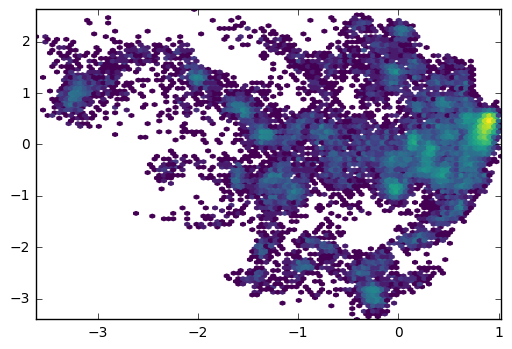

In [6]:
#histogram

%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
txx = np.concatenate(tica_trajs)
plt.hexbin(txx[:,0], txx[:,1], bins='log', mincnt=1, cmap='viridis')

In [7]:
#clustering

from msmbuilder.cluster import MiniBatchKMeans
clusterer = MiniBatchKMeans(n_clusters=100)
clustered_trajs = tica_trajs.fit_transform_with(
    clusterer, 'kmeans/', fmt='dir-npy'
)

print(tica_trajs[0].shape)
print(clustered_trajs[0].shape)

(1000L, 4L)
(1000L,)


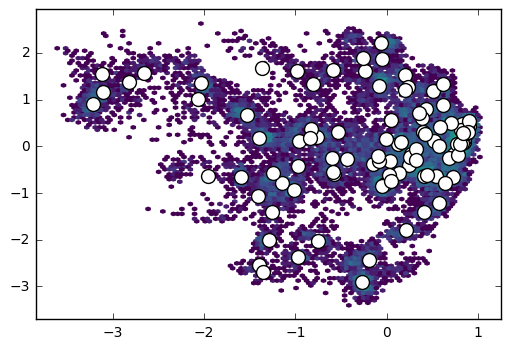

In [8]:
#show cluster

plt.hexbin(txx[:,0], txx[:,1], bins='log', mincnt=1, cmap='viridis')
plt.scatter(clusterer.cluster_centers_[:,0],
            clusterer.cluster_centers_[:,1], 
            s=100, c='w')

In [9]:
#msm builder

from msmbuilder.msm import MarkovStateModel
from msmbuilder.utils import dump
msm = MarkovStateModel(lag_time=2, n_timescales=20)
msm.fit(clustered_trajs)

MSM contains 1 strongly connected component above weight=0.50. Component 0 selected, with population 100.000000%


MarkovStateModel(ergodic_cutoff='on', lag_time=2, n_timescales=20,
         prior_counts=0, reversible_type='mle', sliding_window=True,
         verbose=True)

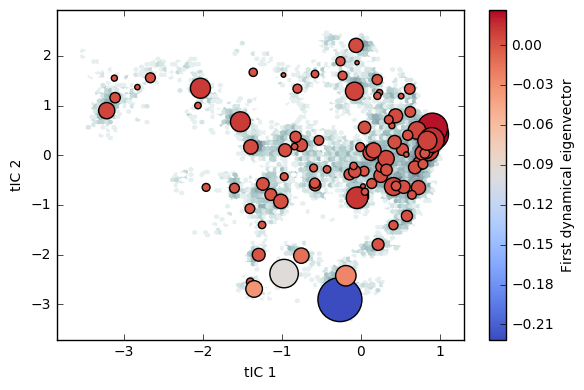

In [10]:
plt.hexbin(txx[:, 0], txx[:, 1], bins='log', mincnt=1, cmap="bone_r")
plt.scatter(clusterer.cluster_centers_[msm.state_labels_, 0],
            clusterer.cluster_centers_[msm.state_labels_, 1],
            s=1e4 * msm.populations_,       # size by population
            c=msm.left_eigenvectors_[:, 1], # color by eigenvector
            cmap="coolwarm") 
plt.colorbar(label='First dynamical eigenvector')
plt.xlabel('tIC 1')
plt.ylabel('tIC 2')
plt.tight_layout()

In [11]:
msm.timescales_

array([ 4195.60421472,  1196.98468582,   836.59600917,   630.68244253,
         335.30776371,   290.06103751,   244.62298861,   190.39758939,
         129.49764185,   116.38684752,   111.62217931,   102.26881564,
          88.47431109,    81.23287306,    74.2348497 ,    68.29250408,
          65.07402827,    60.23370532,    57.50407484,    52.7437593 ])

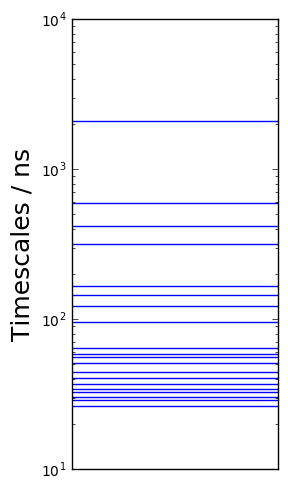

In [12]:

plt.subplots(figsize=(3,5))
plt.hlines(msm.timescales_ * to_ns, 0, 1, color='b')
plt.yscale('log')
plt.xticks([])
plt.ylabel("Timescales / ns", fontsize=18)
plt.tight_layout()

In [13]:
#macrostate model

from msmbuilder.lumping import PCCAPlus
pcca = PCCAPlus.from_msm(msm, n_macrostates=4)
macro_trajs = pcca.transform(clustered_trajs)

Optimization terminated successfully.
         Current function value: -3.990986
         Iterations: 9
         Function evaluations: 98


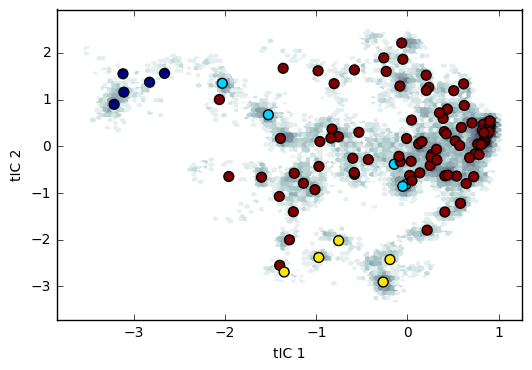

In [14]:
plt.hexbin(txx[:, 0], txx[:, 1], bins='log', mincnt=1, cmap="bone_r")
plt.scatter(clusterer.cluster_centers_[msm.state_labels_, 0],
            clusterer.cluster_centers_[msm.state_labels_, 1],
            s=50,
            c=pcca.microstate_mapping_,
)
plt.xlabel('tIC 1')
plt.ylabel('tIC 2')